<a href="https://colab.research.google.com/github/saurabhsharmagwl/SentimentBasedProductRecommendationSystem/blob/main/Sentiment_Based_Product_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Intentionally Left blank

In [3]:
#Lets mount the drive first.
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks/capstone/sample30.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



**Import the  required packages**



In [4]:
#Importing required libraries.
import numpy as np
import pandas as pd
import re
import time
import pickle
from collections import Counter
from datetime import datetime
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)
pd.set_option("display.precision", 2)
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

In [5]:
#Modelling 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

**Read the databaset** 

In [6]:
# Read the dataset
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/capstone/sample30.csv')

In [7]:
#Check the top 5 records in the dataframe.
df.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


In [8]:
#Check the dataframe shape
df.shape

(30000, 15)

# **Task 1: Data Cleaning and Pre-Processing**

In [9]:
#Checking the null values count for each column
df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [10]:
#Checking the dataframe column information
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [11]:
# As we only have "reviews_rating" column in integer, lets check out its statistics values.
df.describe()

,reviews_rating
count,30000.00
mean,4.48
std,0.99
min,1.00
25%,4.00
50%,5.00
75%,5.00
max,5.00


In [12]:
# This will show how many records counts are available against each rating number.
df['reviews_rating'].value_counts() 

5    20831
4     6020
1     1384
3     1345
2      420
Name: reviews_rating, dtype: int64

In [13]:
# Remove the missing row of user_sentiment
df = df[~df.user_sentiment.isnull()]

In [14]:
# This will display the count of "user_sentiments" data.
df['user_sentiment'].value_counts() 

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64

Text(0.5, 0, 'figure 1- reviews_rating pattern ')

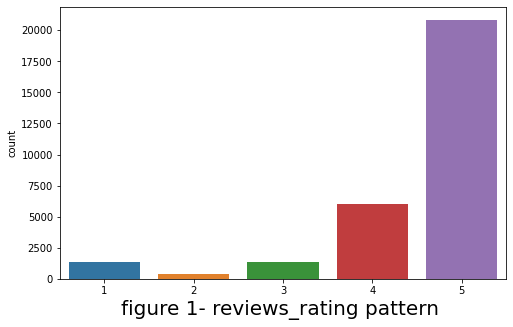

In [15]:
# A chart showing review counts and rating
plt.figure(figsize=(8,5))
ax = sns.countplot(x='reviews_rating', data=df)
plt.xlabel('figure 1- reviews_rating pattern ', fontsize=20)

Text(0.5, 0, 'figure 2- reviews_rating pattern ')

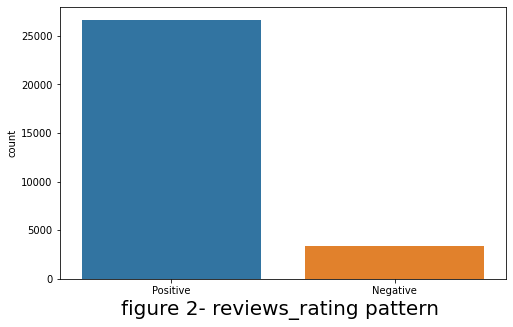

In [16]:
# A chart to show user_sentiment distribution
plt.figure(figsize=(8,5))
ax = sns.countplot(x='user_sentiment', data=df)
plt.xlabel('figure 2- reviews_rating pattern ', fontsize=20)

Text(0.5, 0, 'figure 3- user_sentiment v/s reviews_rating')

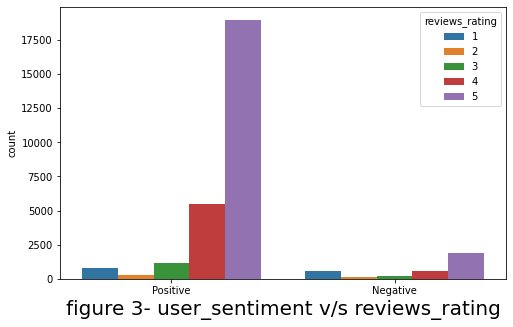

In [17]:
# A chart to showcase user_sentiments based on reviews_rating
plt.figure(figsize=(8,5))
ax = sns.countplot(x='user_sentiment', hue="reviews_rating", data=df)
plt.xlabel('figure 3- user_sentiment v/s reviews_rating', fontsize=20)

**Inference**
- we can see that where user_sentiment is negetive, we also have review_rating as 4 and 5 in big numbers. The only possible reason is that these values are given wrong. 
- we can not train our dataset with incorrect information, hence we will take review_rating 4 & 5 out from the negetive user_sentiments.

In [18]:
#create a new dataframe to check negetive review with higher rating.
df_check1 = df[['id', 'brand', 'categories','manufacturer','name', 'reviews_date'	,'reviews_didPurchase',	'reviews_doRecommend','reviews_rating', 'reviews_text','reviews_title', 'reviews_username',	'user_sentiment']]
						

In [19]:
# Checking how many records are coming against Positive and Negative user_sentiments and what are their review_ratings
pd.crosstab(df_check1["user_sentiment"], df_check1["reviews_rating"], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
Negative,597,140,220,550,1860,3367
Positive,787,280,1125,5470,18970,26632
All,1384,420,1345,6020,20830,29999


**Inference**
- This proves again that Negative sentiments are also holding review_rating as 4 & 5 which ideally not acceptable. 
- Similarily a positive user_sentiment should not have 1,2 rating.
   We will take some actions against incorrect review_rating.

In [20]:
#Lowercasing the user_sentiment values
df_check1['user_sentiment'] = df_check1['user_sentiment'].str.lower()

In [21]:
#map the categorical user_sentiment to numerical 1 or 0 for better modelling
df_check1['user_sentiment'] = df_check1['user_sentiment'].map({'positive':1,'negative':0})

In [22]:
df_check1.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,1
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,rebecca,0
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0


In [23]:
#checking the review_rating mapping with categorical values of user_sentiment.
pd.crosstab(df_check1["user_sentiment"], df_check1["reviews_rating"], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0,597,140,220,550,1860,3367
1,787,280,1125,5470,18970,26632
All,1384,420,1345,6020,20830,29999


In [24]:
#Here we are updating all review_rating (1's & 2's) in the positive user_sentiment 
df_check1.loc[(df_check1["user_sentiment"]==1) & (df_check1["reviews_rating"]<4), "user_sentiment"] = 0

In [25]:
#Here we are updating all review_rating(1's & 2's) in the negetive user_sentiment
df_check1.loc[(df_check1["user_sentiment"]==0) & (df_check1["reviews_rating"]>=4), "user_sentiment"] = 1

In [26]:
#checking the review_rating mapping with categorical values of user_sentiment.
pd.crosstab(df_check1["user_sentiment"], df_check1["reviews_rating"], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0,1384,420,1345,0,0,3149
1,0,0,0,6020,20830,26850
All,1384,420,1345,6020,20830,29999


In [27]:
# We have date colums as well, here we are trying to divide this columns for our analysis.
# Refer reviews_onlydate column, splitting it into seperate columns of Date(%d), Month(%m), and Year(%Y)

# Step1: Extract 'date' component from the 'reviews_date' column AND writing it to 'reviews_onlydate' 
df_check1['reviews_onlydate'] = df_check1['reviews_date'].str[:10]
df_check1['reviews_onlydate'].head()

# Step2: Segregate date component into seperate columns of Date(format %d), Month(format %m), and Year(format %Y)
# Next set the datatype for the extracted date components (Date, Month, Year)
df_check1['reviews_onlydate'] = pd.to_datetime(df_check1['reviews_onlydate'], errors='coerce').dt.date
df_check1['reviews_onlydate'].fillna(df_check1['reviews_onlydate'].value_counts().idxmax(),inplace=True)
df_check1['reviews_onlydate'] = pd.to_datetime(df_check1.reviews_onlydate, format='%Y-%m-%d')
df_check1['reviews_onlydate'].head()

0   2012-11-30
1   2017-07-09
2   2017-07-09
3   2016-01-06
4   2016-12-21
Name: reviews_onlydate, dtype: datetime64[ns]

In [28]:
# We are creating 3 different dataframes for day, month and year respectively.
df_check1['day'] =df_check1['reviews_onlydate'].dt.day
df_check1['month'] =df_check1['reviews_onlydate'].dt.month 
df_check1['year'] =df_check1['reviews_onlydate'].dt.year

Text(0.5, 0, 'figure 4')

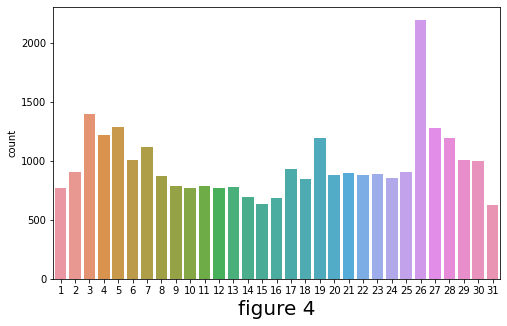

In [29]:
# A Chart to display day when most number of ratings were given.
plt.figure(figsize=(8,5))
ax = sns.countplot(x='day', data=df_check1)
plt.xlabel('figure 4', fontsize=20)

Text(0.5, 0, 'figure 5 ')

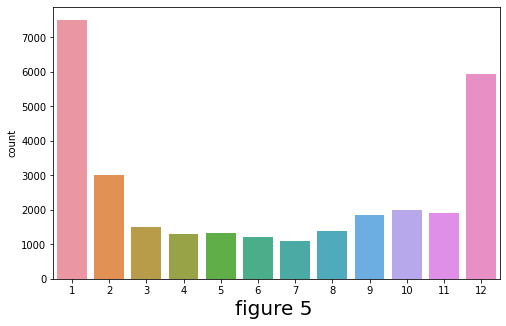

In [30]:
# A Chart to display month when most number of ratings were given.
plt.figure(figsize=(8,5))
ax = sns.countplot(x='month', data=df_check1)
plt.xlabel('figure 5 ', fontsize=20)

Text(0.5, 0, 'figure 6')

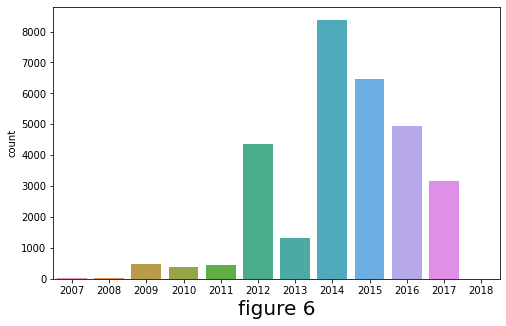

In [31]:
# A Chart to display year when most number of ratings were given.
plt.figure(figsize=(8,5))
ax = sns.countplot(x='year', data=df_check1) 
plt.xlabel('figure 6', fontsize=20)

Text(0.5, 20.80000000000001, 'figure 8')

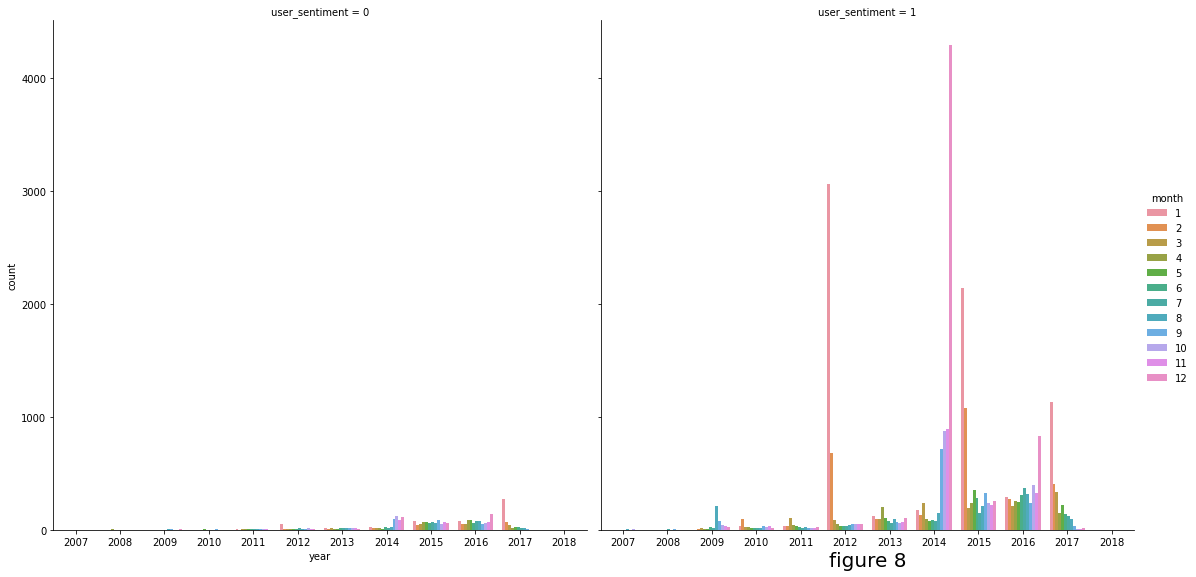

In [32]:
# A chart to display user_sentiment report on the basis of years and month.
g = sns.catplot(x="year", hue="month", col="user_sentiment",
                data=df_check1, kind="count",
                height=8, aspect=1);
plt.xlabel('figure 8', fontsize=20)

In [33]:
# Jumping on to new column "brand"
df_check1["brand"].value_counts()

Clorox                   10585
Warner Home Video         3325
Disney                    1199
L'oreal Paris             1186
FOX                        887
                         ...  
Pacific Natural Foods        1
Noosa                        1
Southern Enterprises         1
SLOAN VALVE COMPANY          1
Universal Music              1
Name: brand, Length: 214, dtype: int64

Text(0.5, 0, 'figure 9')

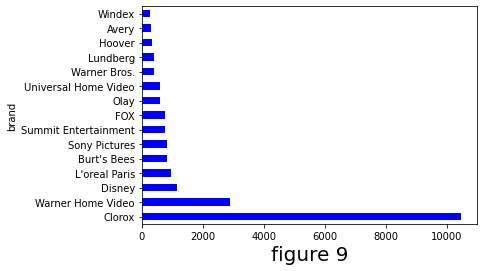

In [34]:
# Filter the top 15 brands among the positive sentiments
df_check1[df_check1['user_sentiment']==1].groupby('brand')['brand'].count().sort_values(ascending=False)[:15].plot(kind='barh',color='b')
plt.xlabel('figure 9', fontsize=20)

Text(0.5, 0, 'figure 10')

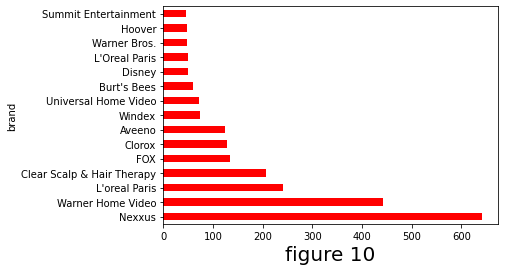

In [35]:
# Filter the top 15 brands among the negative sentiments
df_check1[df_check1['user_sentiment']==0].groupby('brand')['brand'].count().sort_values(ascending=False)[:15].plot(kind='barh', color='r')
plt.xlabel('figure 10', fontsize=20)

In [36]:
# Moving on to new column "categories"
df_check1["categories"].value_counts()

Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Cleaning & Janitorial Supplies,Cleaners & Disinfectants,Cleaning Wipes & Pads,Cleaning Solutions,Housewares,Target Restock,Food & Grocery,Paper Goods,Wipes,All Purpose Cleaners    8545
Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys                                                                                                                                                                                                                                                                                                                                                                                                   3325
Household Chemicals,Household Cleaners,Bath & 

**Inference**
- The product categgories values are too big to judge, hence we will break them in better categories to easy read and process

In [37]:
# Providing Meaningfull names to Categories 
df_check1["new_category"] = df_check1["categories"].apply(lambda x: x.split(",")[0])


In [38]:
df_check1.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_onlydate,day,month,year,new_category
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1,2012-11-30,30,11,2012,Movies
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1,2017-07-09,9,7,2017,Food
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,1,2017-07-09,9,7,2017,Food
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,rebecca,0,2016-01-06,6,1,2016,Personal Care
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0,2016-12-21,21,12,2016,Personal Care


**After checking the new_category, we have derived their better values**

In [39]:
df_check1['new_category'] = df_check1['new_category'].replace("Food","Food and Beverage")
df_check1['new_category'] = df_check1['new_category'].replace("Home","Home Essentials")
df_check1['new_category'] = df_check1['new_category'].replace("Household Essentials","Home Essentials")
df_check1['new_category'] = df_check1['new_category'].replace("Brand Shop","Home Essentials")
df_check1['new_category'] = df_check1['new_category'].replace("Featured Brands","Home Essentials")
df_check1['new_category'] = df_check1['new_category'].replace("Home Improvement","Home Essentials")
df_check1['new_category'] = df_check1['new_category'].replace("Movies","Entertainment: Movies and TV")
df_check1['new_category'] = df_check1['new_category'].replace("Movies & TV Shows","Entertainment: Movies and TV")
df_check1['new_category'] = df_check1['new_category'].replace("Household Chemicals","Home Essentials")
df_check1['new_category'] = df_check1['new_category'].replace("Music on CD or Vinyl","Entertainment: Music Instruments")
df_check1['new_category'] = df_check1['new_category'].replace("Pro Audio","Entertainment: Music Instruments")
df_check1['new_category'] = df_check1['new_category'].replace("Baby","Children Goods")
df_check1['new_category'] = df_check1['new_category'].replace("Kids' Rooms","Children Goods")
df_check1['new_category'] = df_check1['new_category'].replace("Furniture","Home Essentials")
df_check1['new_category'] = df_check1['new_category'].replace("Video Games","Games Sports and Outdoors")
df_check1['new_category'] = df_check1['new_category'].replace("Sports & Outdoors","Games Sports and Outdoors")
df_check1['new_category'] = df_check1['new_category'].replace("Mobile","Electronic Goods")
df_check1['new_category'] = df_check1['new_category'].replace("Photography","Electronic Goods")
df_check1['new_category'] = df_check1['new_category'].replace("Patio & Garden","Home Garden Autos and Gifts")
df_check1['new_category'] = df_check1['new_category'].replace("Gift Finder","Home Garden Autos and Gifts")
df_check1['new_category'] = df_check1['new_category'].replace("Auto & Tires","Home Garden Autos and Gifts")
df_check1['new_category'] = df_check1['new_category'].replace("Kitchen & Dining","Food and Beverage")
df_check1['new_category'] = df_check1['new_category'].replace("Food & Beverage","Food and Beverage")
df_check1['new_category'] = df_check1['new_category'].replace("Party & Occasions","Celebrations")
df_check1['new_category'] = df_check1['new_category'].replace("Party Supplies","Celebrations")
df_check1['new_category'] = df_check1['new_category'].replace("Office","School & Office Supplies")
df_check1['new_category'] = df_check1['new_category'].replace("Beauty","Health Beauty and Personal Care")
df_check1['new_category'] = df_check1['new_category'].replace("Personal Care","Health Beauty and Personal Care")
df_check1['new_category'] = df_check1['new_category'].replace("Health","Health Beauty and Personal Care")

Text(0.5, 0, 'figure 11')

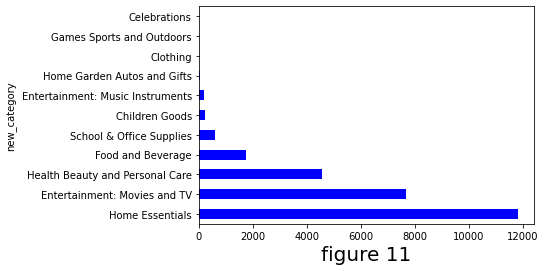

In [40]:
# Filter the top 15 categories among the positive sentiments
df_check1[df_check1['user_sentiment']==1].groupby('new_category')['new_category'].count().sort_values(ascending=False)[:15].plot(kind='barh',color='b')
plt.xlabel('figure 11', fontsize=20)

Text(0.5, 0, 'figure 12')

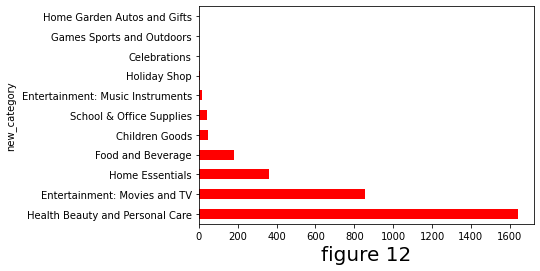

In [41]:
# Filter the top 15 brands among the negative sentiments
df_check1[df_check1['user_sentiment']==0].groupby('new_category')['new_category'].count().sort_values(ascending=False)[:15].plot(kind='barh', color='r')
plt.xlabel('figure 12', fontsize=20)

In [42]:
# Moving on to new column "categories"
df_check1["manufacturer"].value_counts()

Clorox                                8546
Test                                  3325
AmazonUs/CLOO7                        2039
L'oreal Paris                         1232
Walt Disney                           1142
                                      ... 
Pacific Foods of Oregon, Inc.            1
Unfi                                     1
Herr's                                   1
Southern Enterprises                     1
Universal Music Group / Cash Money       1
Name: manufacturer, Length: 227, dtype: int64

Text(0.5, 0, 'figure 13')

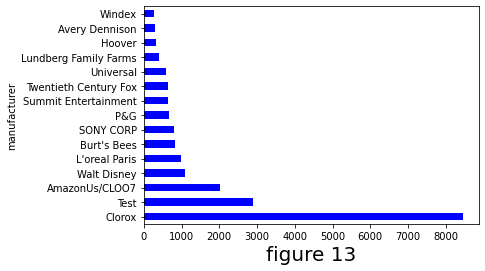

In [43]:
# Filter the top 15 categories among the positive sentiments
df_check1[df_check1['user_sentiment']==1].groupby('manufacturer')['manufacturer'].count().sort_values(ascending=False)[:15].plot(kind='barh',color='b')
plt.xlabel('figure 13', fontsize=20)

Text(0.5, 0, 'figure 14')

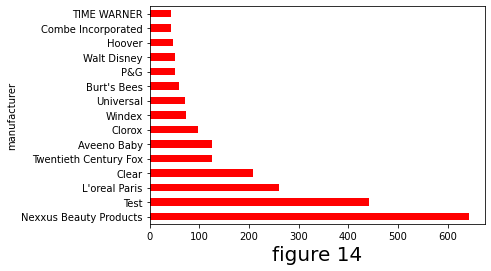

In [44]:
# Filter the top 15 brands among the negative sentiments
df_check1[df_check1['user_sentiment']==0].groupby('manufacturer')['manufacturer'].count().sort_values(ascending=False)[:15].plot(kind='barh', color='r')
plt.xlabel('figure 14', fontsize=20)

In [45]:
#removing nan/null from username
df_check1 = df_check1[~df_check1.reviews_username.isnull()]

In [46]:
df_check1["reviews_title"] = df_check1["reviews_title"].fillna('')

In [47]:
df_check1.isnull().sum()

id                         0
brand                      0
categories                 0
manufacturer             141
name                       0
reviews_date              40
reviews_didPurchase    14005
reviews_doRecommend     2541
reviews_rating             0
reviews_text               0
reviews_title              0
reviews_username           0
user_sentiment             0
reviews_onlydate           0
day                        0
month                      0
year                       0
new_category               0
dtype: int64

# **Task 2: Text Processing**

In [48]:
#Importing more libraries for further use.
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
import string
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer

# Download NLTK packages
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [49]:
# Lets understand presence of duplicate reviews in dataset by Listing count of duplicate reviews
duplicates = df_check1[df_check1.duplicated(subset={"reviews_username","id"})]
duplicates.reviews_username.value_counts()

byamazon customer    39
mike                 24
chris                19
tony                  7
thomas                6
                     ..
spidysgirl            1
gissela               1
dkane514              1
sharvey               1
filo123               1
Name: reviews_username, Length: 2115, dtype: int64

In [50]:
# Lets take example of User (Reviewer/Shopper) = 'byamazon customer' to look at review data
duplicates[duplicates['reviews_username'] == 'byamazon customer']

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_onlydate,day,month,year,new_category
16799,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown Rice,Meal Solutions, Grains & Pasta,Grains & Rice,Grocery & Gourmet Food,Dried Beans, Grains & Rice,Brown",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2017-01-07T00:00:00.000Z,NaN,NaN,4,"Good but if you like it, get it in quantity",Yum,byamazon customer,1,2017-01-07,7,1,2017,Food and Beverage
16807,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown Rice,Meal Solutions, Grains & Pasta,Grains & Rice,Grocery & Gourmet Food,Dried Beans, Grains & Rice,Brown",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2015-08-19T00:00:00.000Z,NaN,NaN,4,RICE LOOKS GOOD.,RICE IS FINE,byamazon customer,1,2015-08-19,19,8,2015,Food and Beverage
16812,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown Rice,Meal Solutions, Grains & Pasta,Grains & Rice,Grocery & Gourmet Food,Dried Beans, Grains & Rice,Brown",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2015-04-08T00:00:00.000Z,NaN,NaN,4,"I love the zip lock seal on these bags (unique from other zip locks). The rice isn't as consistently dark as another brand I buy, but it's still very good.",I love the zip lock seal on these bags (unique from ...,byamazon customer,1,2015-04-08,8,4,2015,Food and Beverage
16824,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown Rice,Meal Solutions, Grains & Pasta,Grains & Rice,Grocery & Gourmet Food,Dried Beans, Grains & Rice,Brown",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2011-07-20T00:00:00.000Z,NaN,NaN,4,"Lundberg Jubilee is a blend of sweet brown rice, short and long grain brown rice and colorful red and black whole grain Wehani and Japonica rice varieties which are also very round and short-grained. This product looks very pretty in the package and cooks up nicely.However, I bought this rice as...",Beautiful and High-Quality Rice But Too Much Short-Grain For My Taste,byamazon customer,1,2011-07-20,20,7,2011,Food and Beverage
16841,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown Rice,Meal Solutions, Grains & Pasta,Grains & Rice,Grocery & Gourmet Food,Dried Beans, Grains & Rice,Brown",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2017-06-05T00:00:00.000Z,NaN,NaN,5,This takes much longer to cook but the taste is very good. The health benefits are also great.,Happy,byamazon customer,1,2017-06-05,5,6,2017,Food and Beverage
16850,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown Rice,Meal Solutions, Grains & Pasta,Grains & Rice,Grocery & Gourmet Food,Dried Beans, Grains & Rice,Brown",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2017-04-20T00:00:00.000Z,NaN,NaN,5,Great rice in a small package...I'll be buying this again.,Recommended,byamazon customer,1,2017-04-20,20,4,2017,Food and Beverage
16904,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown Rice,Meal Solutions, Grains & Pasta,Grains & Rice,Grocery & Gourmet Food,Dried Beans, Grains & Rice,Brown",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2016-07-03T00:00:00.000Z,NaN,NaN,5,"Very tasty! Very earthy rice great for breakfast or mixed in home made bean burgers. Or yummy with onion, carrots and garlic stirred in before cooking and it is so fragrant! We love Lindberg rice! Always delicious! Always fragrant!",Lindberg is just the best!,byamazon customer,1,2016-07-03,3,7,2016,Food and Beverage
16920,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown Rice,Meal Solutions, Grains & Pasta,Grains & Rice,Grocery & Gourmet Food,Dried Beans, Grains & Rice,Brown",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2016-06-23T00:00:00.000Z,NaN,NaN,5,It was great. Very convenient in the 1 lb bags.,Five Stars,byamaz

**- Inference:**
- User (Reviewer/Shopper) 'byamazon customer' has written multiple reviews at approximately same time.
- Reviews are for same product, same Brand, but different flavors, different review titles, and different ratings
- To avoid confusion this duplication in data causes, we can proceed taking Mean of Ratings for such duplicate reviews thus making data meaningful

In [51]:
df_processing=df_check1

In [52]:
df_processing.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_onlydate,day,month,year,new_category
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1,2012-11-30,30,11,2012,Entertainment: Movies and TV
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1,2017-07-09,9,7,2017,Food and Beverage
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,1,2017-07-09,9,7,2017,Food and Beverage
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,rebecca,0,2016-01-06,6,1,2016,Health Beauty and Personal Care
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0,2016-12-21,21,12,2016,Health Beauty and Personal Care


In [53]:
# As decided, Take Mean of Ratings

df_processing['avg_ratings'] = df_processing.groupby(['id','reviews_username'])['reviews_rating'].transform('mean')
df_processing['avg_ratings']=df_processing['avg_ratings'].round(2)
df_processing[['id','reviews_username','reviews_rating','avg_ratings']]

,id,reviews_username,reviews_rating,avg_ratings
0,AV13O1A8GV-KLJ3akUyj,joshua,5,5.0
1,AV14LG0R-jtxr-f38QfS,dorothy w,5,5.0
2,AV14LG0R-jtxr-f38QfS,dorothy w,5,5.0
3,AV16khLE-jtxr-f38VFn,rebecca,1,1.0
4,AV16khLE-jtxr-f38VFn,walker557,1,1.0
...,...,...,...,...
29995,AVpfW8y_LJeJML437ySW,laurasnchz,5,5.0
29996,AVpfW8y_LJeJML437ySW,scarlepadilla,5,5.0
29997,AVpfW8y_LJeJML437ySW,liviasuexo,5,5.0
29998,AVpfW8y_LJeJML437ySW,ktreed95,5,5.0


In [54]:
# Now delete duplicate Reviews for same product ID and User (Reviewer/Shopper)
df_processing =  df_processing.drop_duplicates(subset={"reviews_username","id"},keep="first")

In [55]:
# Validate deletion of duplicates for User = 'byamazon customer'
df_processing[df_processing['reviews_username'] == 'byamazon customer']

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_onlydate,day,month,year,new_category,avg_ratings
16778,AVpf9pzn1cnluZ0-uNTM,Lundberg,"Food,Packaged Foods,Packaged Grains,Rice,Brown Rice,Meal Solutions, Grains & Pasta,Grains & Rice,Grocery & Gourmet Food,Dried Beans, Grains & Rice,Brown",Lundberg Family Farms,"Lundberg Wehani Rice, 25lb",2016-02-03T00:00:00.000Z,NaN,NaN,1,"A waste of my money I don't know what kind of black rice this supposed to be,,,it loses most of its color during the cooking process I think it's dyed plus the grains are really short every black rice I've ever had where long grain and did not lose all that coloring doing the cooking process... ...",Dyed Rice,byamazon customer,0,2016-02-03,3,2,2016,Food and Beverage,4.58
26450,AVpfPPkEilAPnD_xX3cP,Aveeno,"Personal Care,Sun Care,Featured Brands,Health & Beauty,Johnson & Johnson Beauty,Johnson & Johnson,Beauty,Skin Care,Sun & Tanning,Health,Beauty & Personal Care,Sunscreens & Tanning Products,Sunscreens,Facial Sunscreens,Sun Protection & Tanning,Sunscreen,Body Sunscreens,Health & Wellness,Sun Prote...",Aveeno Baby,"Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",2017-07-05T00:00:00.000Z,NaN,NaN,1,"The first time I used in my infant, he rubbed his eyes and cried. Have never used it again for him. Do yourself a favor and buy something else for an infant or toddler that is tear free.",Not Tear Free Not Useful,byamazon customer,0,2017-07-05,5,7,2017,Health Beauty and Personal Care,3.41


In [56]:
# Understand new size of dataset after removal of duplicate Reviews
size_diffrence = df_processing['id'].size/df_check1['id'].size

print("%.f%% reduction in data post duplicate review deletion"%((1-size_diffrence)*100))
print("Revised size of data = ",df_processing['id'].size,"rows ")

8% reduction in data post duplicate review deletion
Revised size of data =  27588 rows 


In [57]:
df_processing.shape

(27588, 19)

In [58]:
df_clean = df_processing[['id','name', 'reviews_text', 'user_sentiment']]

In [59]:
#function to clean the text and remove all the unnecessary elements.
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub("\[\s*\w*\s*\]", "", text)
    dictionary = "abc".maketrans('', '', string.punctuation)
    text = text.translate(dictionary)
    text = re.sub("\S*\d\S*", "", text)
    
    return text
 

In [60]:
df_clean["reviews_text"] = df_clean.reviews_text.apply(lambda x: clean_text(x))

In [61]:
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [62]:
# Initiatilize StopWords
stop_words = set(stopwords.words('english'))

def remove_stopword(text):
    words = [word for word in text.split() if word.isalpha() and word not in stop_words]
    return " ".join(words)

In [63]:
lemmatizer = WordNetLemmatizer()
# Lemmatize the sentence
def lemma_text(text):
    word_pos_tags = nltk.pos_tag(word_tokenize(remove_stopword(text))) # Get position tags
    # Map the position tag and lemmatize the word/token
    words =[lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] 
    return " ".join(words)

In [64]:
df_clean["reviews_text_derived"] = df_clean.reviews_text.apply(lambda x: lemma_text(x))

In [65]:
df_clean.head(5)

,id,name,reviews_text,user_sentiment,reviews_text_derived
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album its very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it rating all the way her metaphors are just crazy,1,love album good hip hop side current pop sound hype listen everyday gym give rating way metaphor crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,good flavor this review was collected as part of a promotion,1,good flavor review collect part promotion
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,i read through the reviews on here before looking in to buying one of the couples lubricants and was ultimately disappointed that it didnt even live up to the reviews i had read for starters neither my boyfriend nor i could notice any sort of enhanced or captivating sensation what we did notice ...,0,read review look buy one couple lubricant ultimately disappointed didnt even live review read starter neither boyfriend could notice sort enhanced captivate sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lack captivate sensation ...
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,my husband bought this gel for us the gel caused irritation and it felt like it was burning my skin i wouldnt recommend this gel,0,husband buy gel u gel caused irritation felt like burn skin wouldnt recommend gel
5,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,my boyfriend and i bought this to spice things up in the bedroom and we were both highly disappointed in this product we bought this one because we absolutely love the ky yours and mine and we thought this would have a similar affect but it did absolutely nothing do not buy,0,boyfriend buy spice thing bedroom highly disappointed product buy one absolutely love ky mine think would similar affect absolutely nothing buy


In [66]:
# Defining a function for plotting Top n Common Words in column

def common_wds(column, terms, title_label):
  all_words_column = ' '.join([text for text in column])
  all_words_column = all_words_column.split()

  fr_dist = FreqDist(all_words_column)
  words_df = pd.DataFrame({'word':list(fr_dist.keys()), 'count':list(fr_dist.values())})

  word_rank = words_df.nlargest(columns="count", n = terms)   # Select Top 20 most frequent words
  plt.figure(figsize=(10,5))
  ax = sns.scatterplot(data=word_rank, x= "count", y = "word", color = "green")
  ax.set(ylabel = 'common words')
  plt.title(title_label, fontsize = 14)
  plt.grid()
  plt.show()

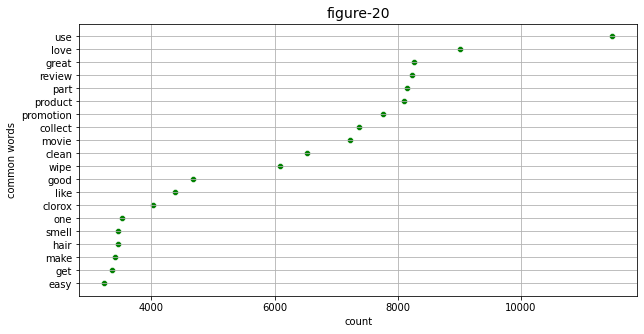

In [67]:
# Plotting Common Words in Review column ranked upto 20
common_wds(df_clean['reviews_text_derived'],20,'figure-20')


In [68]:
# Defining a Function for plotting least occurring words in column

def rare_wds(column, terms, title_label):
  all_words_column = ' '.join([text for text in column])
  all_words_column = all_words_column.split()

  fr_dist = FreqDist(all_words_column)
  words_df = pd.DataFrame({'word':list(fr_dist.keys()), 'count':list(fr_dist.values())})

  # selecting top 20 most frequent words
  word_rank = words_df.nsmallest(columns="count", n = terms) 
  plt.figure(figsize=(10,5))
  ax = sns.scatterplot(data=word_rank, x= "count", y = "word", color = "green")
  ax.set(ylabel = 'rare words')
  plt.title(title_label, fontsize = 14)
  plt.grid()
  plt.show()

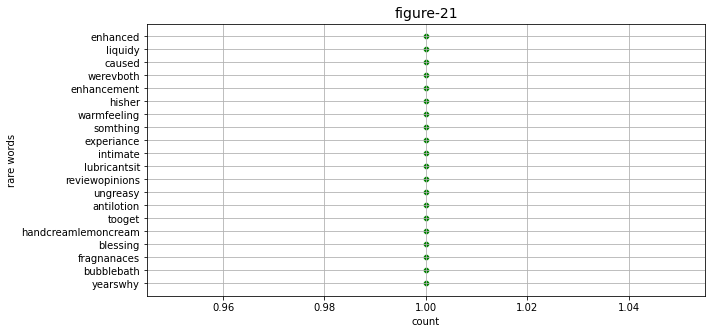

In [69]:
# Plotting Rare Words in Review column ranked upto 20
rare_wds(df_clean['reviews_text_derived'],20, 'figure-21')

(array([1.273e+04, 9.506e+03, 2.927e+03, 1.176e+03, 5.580e+02, 2.410e+02,
        1.720e+02, 8.900e+01, 5.100e+01, 3.800e+01, 2.700e+01, 2.900e+01,
        9.000e+00, 2.000e+00, 7.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
        4.000e+00, 3.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([   0.  ,   73.22,  146.44,  219.66,  292.88,  366.1 ,  439.32,
         512.54,  585.76,  658.98,  732.2 ,  805.42,  878.64,  951.86,
        1025.08, 1098.3 , 1171.52, 1244.74, 1317.96, 1391.18, 1464.4 ,
        1537.62, 1610.84, 1684.06, 1757.28, 1830.5 , 1903.72, 1976.94,
        2050.16, 2123.38, 2196.6 , 2269.82, 2343.04, 2416.26, 2489.48,
        2562.7 , 2635

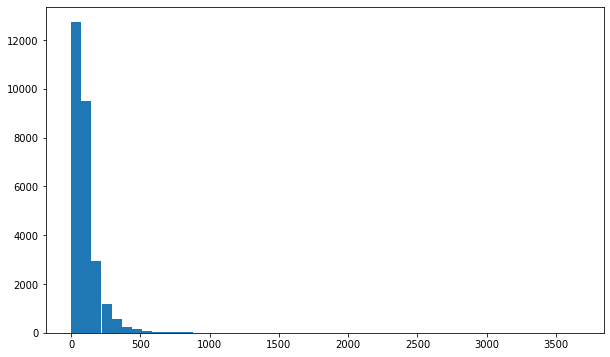

In [70]:
#visualise the data according to the 'reviews_text_derived' character length
plt.figure(figsize=(10,6))
reviews_length = [len(d) for d in df_clean['reviews_text_derived']]
plt.hist(reviews_length, bins = 50)

In [71]:
def getMostCommonWords(reviews, n_most_common):
    # flatten review column into a list of words, and set each to lowercase
    flattened_reviews = [word for review in reviews for word in \
                         review.lower().split()]


    # remove punctuation from reviews
    flattened_reviews = [''.join(char for char in review if \
                                 char not in string.punctuation) for \
                         review in flattened_reviews]


    # remove any empty strings that were created by this process
    flattened_reviews = [review for review in flattened_reviews if review]

    return Counter(flattened_reviews).most_common(n_most_common)

In [72]:
df_positive_review = df_clean[df_clean['user_sentiment']==1]
getMostCommonWords(df_positive_review['reviews_text_derived'],10)

[('use', 10167),
 ('love', 8601),
 ('great', 7872),
 ('review', 7849),
 ('part', 7824),
 ('promotion', 7518),
 ('collect', 7138),
 ('product', 6795),
 ('movie', 6439),
 ('clean', 6337)]

In [73]:
df_positive_review.shape

(24934, 5)

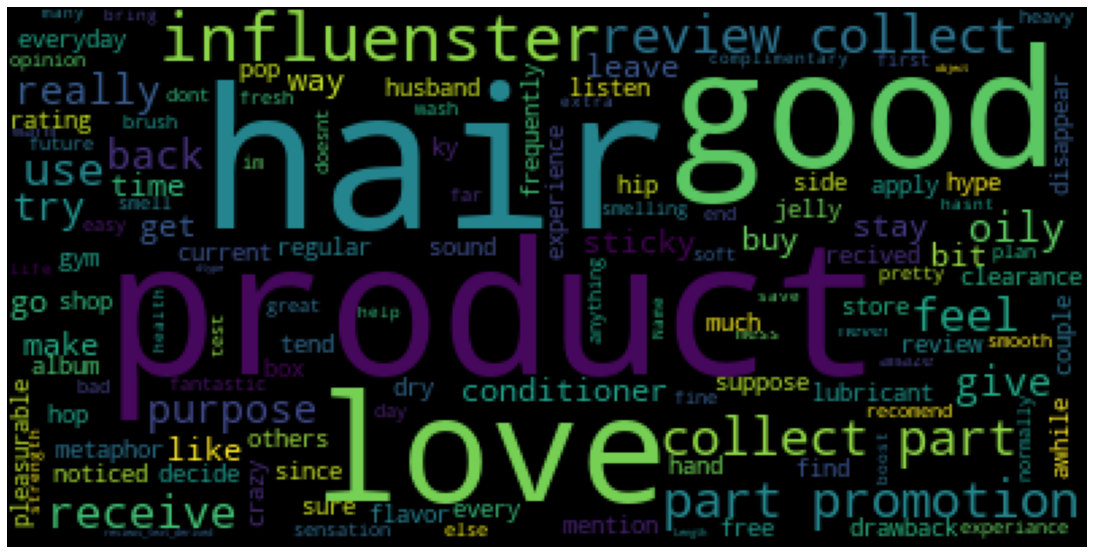

In [74]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text in df_positive_review dataset.
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=stop_words,max_words=200).generate(str(df_positive_review['reviews_text_derived']))

print(wordcloud)
plt.figure(figsize= (15,15), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show();

In [75]:
df_negative_review = df_clean[df_clean['user_sentiment']==0]
getMostCommonWords(df_negative_review['reviews_text_derived'],10)

[('use', 1314),
 ('product', 1311),
 ('hair', 1033),
 ('like', 842),
 ('movie', 789),
 ('formula', 735),
 ('new', 705),
 ('good', 648),
 ('old', 613),
 ('would', 543)]

In [76]:
df_negative_review.shape

(2654, 5)

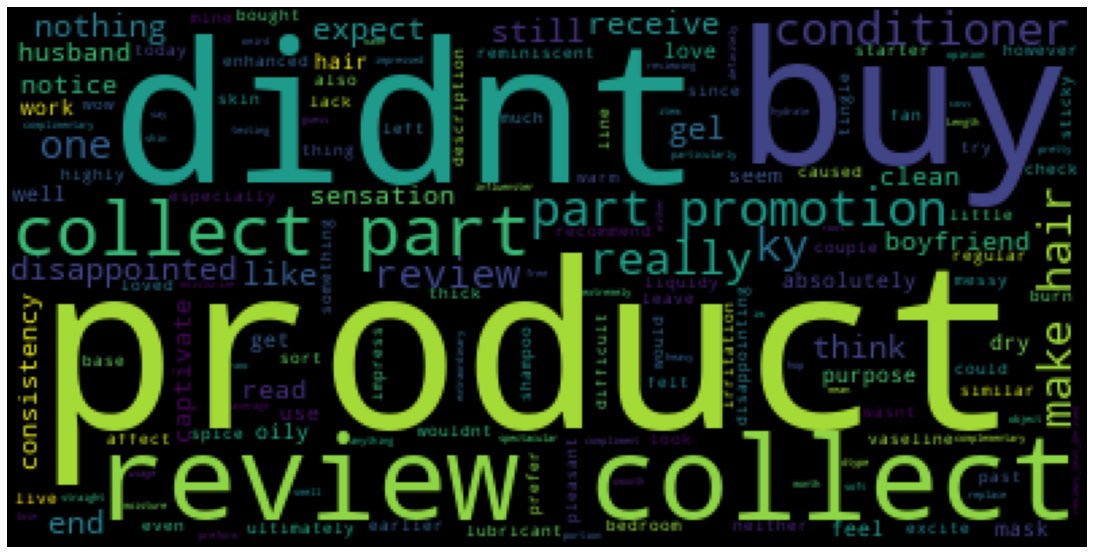

In [77]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text in df_positive_review dataset.
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=stop_words,max_words=200).generate(str(df_negative_review['reviews_text_derived']))

print(wordcloud)
plt.figure(figsize= (15,15), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show();

In [78]:
#function to collect the n-gram frequency of words
def get_top_n_ngram( corpus, n_gram_range ,n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [79]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(df_positive_review['reviews_text_derived'], 2, 10)
pd.DataFrame(common_words)

--1 [[1 1 1 ... 1 1 1]]


,0,1
0,review collect,7118
1,collect promotion,7118
2,clorox wipe,1809
3,easy use,1187
4,use clorox,956
5,love clorox,846
6,love product,716
7,great product,702
8,use product,684
9,disinfect wipe,636


In [80]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(df_negative_review['reviews_text_derived'], 2, 10)
pd.DataFrame(common_words)

--1 [[1 1 1 ... 1 1 1]]


,0,1
0,old formula,261
1,new formula,247
2,review collect,230
3,collect promotion,230
4,bring old,162
5,use product,129
6,exxtra gel,107
7,make hair,99
8,shampoo conditioner,93
9,gel year,92


# **Task 3: Feature Extraction**

In [81]:
X = df_clean['reviews_text_derived']
y = df_clean['user_sentiment']

In [82]:
no_of_classes= len(pd.Series(y).value_counts())

In [83]:
pd.Series(y).value_counts()

1    24934
0     2654
Name: user_sentiment, dtype: int64

To Vectorize the data, using TF-IDF vectorizer method to dervie the features from the textual data

As it's clearly a class-imbalance between positive and negative, let's do SMOTE oversampling technique before modelling

In [84]:
#using TF-IDF vectorizer using the parameters to get 650 features.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=650, max_df=0.9, min_df=7, binary=True, 
                                   ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(df_clean['reviews_text_derived'])

y= df_clean['user_sentiment']

In [85]:
print(tfidf_vectorizer.get_feature_names_out())

['able' 'absolutely' 'absolutely love' 'act' 'action' 'actor' 'actually'
 'add' 'age' 'ago' 'amaze' 'amazing' 'apply' 'area' 'ask' 'available'
 'away' 'awesome' 'baby' 'bad' 'bag' 'balm' 'base' 'bathroom'
 'bathroom kitchen' 'bathroom review' 'beat' 'beautiful' 'bee' 'begin'
 'believe' 'best' 'best buy' 'big' 'bit' 'black' 'bleach' 'blu' 'blu ray'
 'bluray' 'body' 'bottle' 'bought' 'box' 'boy' 'brand' 'break' 'bring'
 'bring old' 'brown' 'burt' 'burt bee' 'buy' 'buying' 'canister' 'car'
 'care' 'carpet' 'carry' 'cast' 'cd' 'chair' 'change' 'character' 'cheap'
 'child' 'chip' 'classic' 'classroom' 'clay' 'clean' 'clean bathroom'
 'clean disinfect' 'clean easy' 'clean fresh' 'clean house'
 'clean kitchen' 'clean mess' 'clean review' 'clean smell' 'clean ups'
 'clean use' 'cleaner' 'cleaning' 'cleanup' 'clear' 'clorox'
 'clorox disinfect' 'clorox product' 'clorox review' 'clorox wipe' 'close'
 'clothes' 'cocoa' 'cold' 'collect' 'collect promotion' 'collected'
 'collected promotion' 'colle

In [86]:
# splitting into test and train
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, random_state=42, test_size=0.25)

In [87]:
# Class imbalance (using SMOTE)
counter = Counter(y_train)
print('Before',counter)

sm = SMOTE()

# transform the dataset
X_train, y_train = sm.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After',counter)

Before Counter({1: 18674, 0: 2017})
After Counter({1: 18674, 0: 18674})


# **Task 4: Model Building**

In [88]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score

import xgboost as xgb
from xgboost import XGBClassifier

In [89]:
# Defining a Function to calculate confusion matrix and display scores for various ML models

def display_model_score(classifier):
    cm = confusion_matrix(y_test, classifier.predict(X_test))
    plot_confusion_matrix(classifier, X_test, y_test,include_values=True,values_format='g',cmap=plt.cm.Greens) 
    p_acc = float(accuracy_score(y_test, classifier.predict(X_test)))
    p_sen = float(format(cm[1][1]/sum(cm[1])))
    p_spe = float(format(cm[0][0]/sum(cm[0])))
    p_pre = float(format(cm[1][1]/((cm[1][1])+(cm[0][1]))))
    p_f1s = float(format(2*cm[1][1]/(((cm[1][1])+(cm[0][1]))+sum(cm[1]))))
    print(classifier)
    print('\n')
    print(f"Accuracy is {p_acc:.4f}")
    print(f"Sensitivity is {p_sen:.4f}")
    print(f"Specificity is {p_spe:.4f}")
    print(f"Precision is {p_pre:.4f}")
    print(f"F1 Score is {p_f1s:.4f}")
    return p_acc, p_sen, p_spe, p_pre, p_f1s

## **Evaluating the model choices**

- Build multiple Machine Learning models among below 4 taking class imbalance and hyperparameter tuning into consideration:  
&emsp;1. Logistic Regression  
&emsp;2. Naive Bayes  
&emsp;3. Random Forest  
&emsp;4. XGBoost  
- Analyse the performance of each of the models
- Confirm the best fit model 

In [90]:

from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


**ML Model 1 - Logistic Regression**

In [91]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
      lr = LogisticRegression(C=c)
      lr.fit(X_train, y_train)
      cm = confusion_matrix(y_test, lr.predict(X_test))
      print('Sensitivity for C = {0} is {1}'.format(c, cm[1][1]/sum(cm[1])))
      print('Specificity for C = {0} is {1}'.format(c, cm[0][0]/sum(cm[0])))
      print('Precision for C = {0} is {1}'.format(c, cm[1][1]/((cm[1][1])+(cm[0][1]))))

Sensitivity for C = 0.01 is 0.7584664536741214
Specificity for C = 0.01 is 0.792778649921507
Precision for C = 0.01 is 0.9729508196721312
Sensitivity for C = 0.05 is 0.820926517571885
Specificity for C = 0.05 is 0.7346938775510204
Precision for C = 0.05 is 0.9681612660135644
Sensitivity for C = 0.25 is 0.8520766773162939
Specificity for C = 0.25 is 0.6938775510204082
Precision for C = 0.25 is 0.9647314161692893
Sensitivity for C = 0.5 is 0.8579872204472844
Specificity for C = 0.5 is 0.6828885400313972
Precision for C = 0.5 is 0.963753813027095
Sensitivity for C = 1 is 0.8615015974440895
Specificity for C = 1 is 0.6781789638932496
Precision for C = 1 is 0.9633797784923187


In [92]:
final_lr = LogisticRegression(C=0.05)
final_lr.fit(X_train, y_train)

LogisticRegression(C=0.05)

LogisticRegression(C=0.05)


Accuracy is 0.8130
Sensitivity is 0.8209
Specificity is 0.7347
Precision is 0.9682
F1 Score is 0.8885


(0.8129621574597651,
 0.820926517571885,
 0.7346938775510204,
 0.9681612660135644,
 0.8884854771784232)

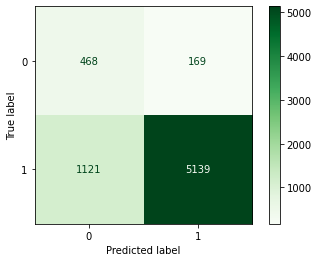

In [93]:
df_lr = display_model_score(final_lr)
df_lr

In [94]:
# saving the model - Logistic Regression
pickle.dump(final_lr, open('/content/drive/MyDrive/ColabNotebooks/capstone/pickle/logistic_regression_model.pkl', 'wb'))
pickle.dump(tfidf_vectorizer, open("/content/drive/MyDrive/ColabNotebooks/capstone/pickle/tfidf.pkl", "wb"))

In [95]:
feature_to_coef = {
    word: coef for word, coef in zip(
     tfidf_vectorizer.get_feature_names(), final_lr.coef_[0])
}

print('Positive Words')
for best_positive in sorted(
    feature_to_coef.items(),
    key=lambda x: x[1],
    reverse=True)[:10]:
    print(best_positive)
    
print('Negative Words')
for best_negative in sorted(
    feature_to_coef.items(),
    key=lambda x: x[1])[:10]:
    print(best_negative)

Positive Words
('love', 4.2847771019284915)
('great', 4.284057222083891)
('clean', 2.7079531099539986)
('wipe', 2.3525146728037787)
('best', 2.1754891179105544)
('use', 2.1517666239768456)
('awesome', 1.9932842253643028)
('movie', 1.9694951990993648)
('easy', 1.9590950484218521)
('promotion', 1.785378505237178)
Negative Words
('formula', -2.3489870000940956)
('ok', -1.9031264970876052)
('bad', -1.7778913144529438)
('gel', -1.7227439339560742)
('change', -1.4326889582188698)
('new formula', -1.3095135417459878)
('didnt', -1.3051858564066359)
('old formula', -1.285098839205385)
('disappointed', -1.2097933474534543)
('bring old', -1.0660266753667156)


**ML Model 2 - Naive Bayes**

In [96]:
# Fitting Naive Bayes Model
nb=MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

MultinomialNB()


Accuracy is 0.7437
Sensitivity is 0.7334
Specificity is 0.8446
Precision is 0.9789
F1 Score is 0.8385


(0.7436566623169494,
 0.7333865814696485,
 0.8445839874411303,
 0.9788912579957356,
 0.8385388127853881)

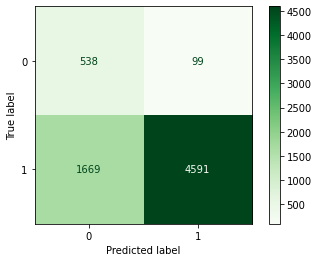

In [97]:
# Test Data Performance Metrics

df_nb = display_model_score(nb)
df_nb


In [98]:
# saving the model - Naive Bayes
pickle.dump(nb, open('/content/drive/MyDrive/ColabNotebooks/capstone/pickle/naive_bayes_model.pkl', 'wb'))

ML Model 3 - Random Forest Classifier (without hyperparameter tuning and with hyperparameter tuning)

In [99]:
# Random Forest classifier without any hyperparameter tuning
from sklearn.model_selection import GridSearchCV
final_rf = RandomForestClassifier()
final_rf.fit(X_train, y_train)

RandomForestClassifier()

RandomForestClassifier()


Accuracy is 0.8991
Sensitivity is 0.9462
Specificity is 0.4364
Precision is 0.9429
F1 Score is 0.9445


(0.8990865593736407,
 0.9461661341853035,
 0.4364207221350079,
 0.9428525947150589,
 0.9445064583001116)

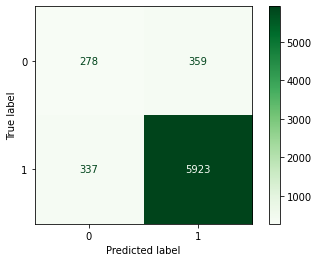

In [100]:
df_rf = display_model_score(final_rf)
df_rf

In [101]:
# saving the model - Random Forest
pickle.dump(final_rf, open('/content/drive/MyDrive/ColabNotebooks/capstone/pickle/random_forest_model.pkl', 'wb'))

In [102]:
# Random Forest classifier with various hyperparameters
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [15, 20],
    'min_samples_leaf': [100,200],
    'min_samples_split': [200,400],
    'n_estimators': [100, 300]
}

# Create a based model
final_rft = RandomForestClassifier()

# Instantiate the grid search model
rf_tuned = GridSearchCV(estimator = final_rft, param_grid = param_grid, scoring='roc_auc', cv = 3, n_jobs = -1,verbose = 1)
rf_tuned.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [15, 20], 'min_samples_leaf': [100, 200],
                         'min_samples_split': [200, 400],
                         'n_estimators': [100, 300]},
             scoring='roc_auc', verbose=1)

In [103]:
# Print best hyperparameters

print("Best AUC-ROC Score on train data: ", rf_tuned.best_score_)
print("Best hyperparameters: ", rf_tuned.best_params_)

Best AUC-ROC Score on train data:  0.914292720953156
Best hyperparameters:  {'max_depth': 20, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 100}


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [15, 20], 'min_samples_leaf': [100, 200],
                         'min_samples_split': [200, 400],
                         'n_estimators': [100, 300]},
             scoring='roc_auc', verbose=1)


Accuracy is 0.7793
Sensitivity is 0.7877
Specificity is 0.6970
Precision is 0.9623
F1 Score is 0.8663


(0.7793243439176454,
 0.7876996805111821,
 0.6970172684458399,
 0.9623341139734582,
 0.8663035839775123)

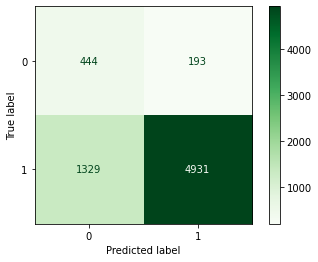

In [104]:
# Test data performance metrics
df_rft = display_model_score(rf_tuned)
df_rft

In [105]:
# saving the model - Random Forest with Hyperparameter Tuning

pickle.dump(rf_tuned, open('/content/drive/MyDrive/ColabNotebooks/capstone/pickle/random_forest_tuned_model.pkl', 'wb'))

ML Model 4 - XGBoost Classifier (without hyperparameter tuning and with hyperparameter tuning)

In [106]:
# XGBoost classifier without any hyperparameter tuning
final_xgb = XGBClassifier(booster='gbtree')
final_xgb.fit(X_train, y_train)

XGBClassifier()

XGBClassifier()


Accuracy is 0.7992
Sensitivity is 0.8109
Specificity is 0.6845
Precision is 0.9619
F1 Score is 0.8800


(0.7991880527765696,
 0.8108626198083068,
 0.6844583987441131,
 0.961910176236498,
 0.8799514605183323)

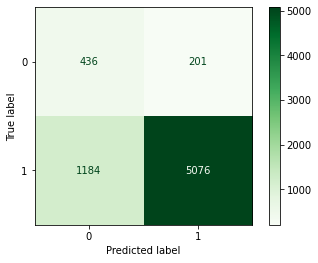

In [107]:
# Displaying Confusion matrix Scores
#Test data performance metrics
df_xgb = display_model_score(final_xgb)
df_xgb

In [108]:
# saving the model - XGBoost

pickle.dump(final_xgb, open('/content/drive/MyDrive/ColabNotebooks/capstone/pickle/xgboost_model.pkl', 'wb'))

In [109]:
# XGBoost classifier with various custom hyperparameters
param_grid = {'learning_rate': [0.001, 0.01], 'max_depth':[ 5, 10],  'n_estimators':[1, 3]}

final_xgb = XGBClassifier(booster='gbtree')

# set up GridSearchCV()
xgb_tuned = GridSearchCV(estimator = final_xgb, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv =3, 
                        verbose = 1,
                        return_train_score=True)

xgb_tuned.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.001, 0.01], 'max_depth': [5, 10],
                         'n_estimators': [1, 3]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [110]:
# print best hyperparameters
print("Best AUC-ROC Score on train data: ", xgb_tuned.best_score_)
print("Best hyperparameters: ", xgb_tuned.best_params_)

Best AUC-ROC Score on train data:  0.8732817328546835
Best hyperparameters:  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 3}


GridSearchCV(cv=3, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.001, 0.01], 'max_depth': [5, 10],
                         'n_estimators': [1, 3]},
             return_train_score=True, scoring='roc_auc', verbose=1)


Accuracy is 0.6599
Sensitivity is 0.6422
Specificity is 0.8336
Precision is 0.9743
F1 Score is 0.7741


(0.6598521096128752,
 0.6421725239616614,
 0.8335949764521193,
 0.9743092583616093,
 0.7741190063547082)

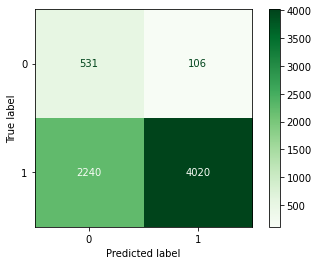

In [111]:
# Displaying Confusion matrix Scores
# Test data performance metrics
df_xgbt = display_model_score(xgb_tuned)
df_xgbt

In [112]:
# saving the model - XGBoost with Hyperparameter Tuning

pickle.dump(xgb_tuned, open('/content/drive/MyDrive/ColabNotebooks/capstone/pickle/xgboost_tuned_model.pkl', 'wb'))

**ML Models Comparison**

In [113]:
# Index: 0=Accuracy, 1=Sensitivity, 2=Specificity, 3=Precision, 4=F1Score

results = {('LR'):[df_lr[0],df_lr[1],df_lr[2],df_lr[3],df_lr[4]],
           ('NB'):[df_nb[0],df_nb[1],df_nb[2],df_nb[3],df_nb[4]],
           ('XGB'):[df_xgb[0],df_xgb[1],df_xgb[2],df_xgb[3],df_xgb[4]],
           ('XGB Tuned'):[df_xgbt[0],df_xgbt[1],df_xgbt[2],df_xgbt[3],df_xgbt[4]],
           ('RF'):[df_rf[0],df_rf[1],df_rf[2],df_rf[3],df_rf[4]],
           ('RF Tuned'):[df_rft[0],df_rft[1],df_rft[2],df_rft[3],df_rft[4]]
          }
pd.DataFrame(results, index=['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1Score'])

,LR,NB,XGB,XGB Tuned,RF,RF Tuned
Accuracy,0.81,0.74,0.80,0.66,0.90,0.78
Sensitivity,0.82,0.73,0.81,0.64,0.95,0.79
Specificity,0.73,0.84,0.68,0.83,0.44,0.70
Precision,0.97,0.98,0.96,0.97,0.94,0.96
F1Score,0.89,0.84,0.88,0.77,0.94,0.87


##### Score driving the model choice:
- Considering the user sentiment data - <i> in user_sentiment column in the sample30.csv dataset</i> - is unambiguous and of high quality, we will look at Accuracy, Precision, and F1Score in choosing our bext model as these are strongly driven on True Positive data.
- While Sensitivity and Specificity do provide good results, here in our case we can ignore these as the sentiment data is high quality and there is less play for True Negative OR False Negative dataset.

##### Observations on above Scores:
- RandomForest has the best Accuracy and F1Score 

##### Inference:
- RandomForest without any hyperparameter tuning is the best model


In [114]:
pickle.dump(tfidf_vectorizer, open('/content/drive/MyDrive/ColabNotebooks/capstone/pickle/tfidf-vectorizer.pkl', 'wb'))

In [115]:
pickle.dump(df_clean, open('/content/drive/MyDrive/ColabNotebooks/capstone/pickle/cleaned-data.pkl', 'wb'))

### **Task 5:Building the Recommendation System**

- User based recommendation
- User based prediction & evaluation
- Item based recommendation
- Item based prediction & evaluation
Different Approaches to develop Recommendation System -

1. Demographic based Recommendation System
2. Content Based Recommendation System
3. Collaborative filtering Recommendation System

In [116]:
# Importing Libraries
from sklearn.metrics.pairwise import pairwise_distances

In [117]:
df_processing.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_onlydate,day,month,year,new_category,avg_ratings
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1,2012-11-30,30,11,2012,Entertainment: Movies and TV,5.0
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1,2017-07-09,9,7,2017,Food and Beverage,5.0


In [118]:
df_recommendation = df_processing[["id", "name", "reviews_rating", "reviews_username"]]


In [119]:
# Checking for null values

df_recommendation.isnull().sum()

id                  0
name                0
reviews_rating      0
reviews_username    0
dtype: int64

Splitting the dataset into train and test


In [120]:
# Test and Train split of the dataset
train, test = train_test_split(df_recommendation, test_size=0.30, random_state=42)

print(train.shape)
print(test.shape)

(19311, 4)
(8277, 4)


In [121]:
product_column = "id"
user_column = "reviews_username"
value_column = "reviews_rating"

In [122]:
# Pivot the train ratings' dataset into matrix format in which columns are products and the rows are user IDs.
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
df_pivot = pd.pivot_table(train,index=user_column, columns = product_column, values = value_column).fillna(0)
df_pivot.head(5)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,...,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfRxSkilAPnD_xYrzm,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfh1gsilAPnD_xdX_S,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVp

Creating dummy train & dummy test dataset

In [123]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()
dummy_train.head()

,id,name,reviews_rating,reviews_username
10354,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,phoebesmom
12495,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,luisa
14491,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,jbsmooth
12787,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,damp123
6417,AVpf385g1cnluZ0-s0_t,"Hormel Chili, No Beans",5,momon


In [124]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train[value_column] = dummy_train[value_column].apply(lambda x: 0 if x>=1 else 1)

In [125]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
dummy_train = pd.pivot_table(dummy_train,index=user_column, columns = product_column, values = value_column).fillna(1)
dummy_train.head(5)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,...,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfRxSkilAPnD_xYrzm,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfh1gsilAPnD_xdX_S,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVp

User Cosine Similarity Matrix
- Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case] 

In [126]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

In [127]:
df_pivot.index.nunique()

17860

In [128]:
user_correlation = cosine_similarity(df_pivot)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
print(user_correlation.shape)

[[1. 0. 0. ... 0. 1. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [1. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]]
(17860, 17860)


In [129]:
user_correlation.shape

(17860, 17860)

### **Prediction User-User**

In [130]:
#filtering out the user_correlation that are negatively correlated
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [131]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 2.38365647,
        0.57353933],
       [0.        , 0.        , 4.5519567 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 4.5519567 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.4975186 , ..., 0.        , 0.        ,
        3.53553391],
       [0.        , 0.        , 0.        , ..., 0.        , 2.38365647,
        0.57353933],
       [0.        , 0.        , 0.4975186 , ..., 0.        , 0.        ,
        3.53553391]])

In [132]:
#since we are interested in products that are not rated by the user, we multiply with dummy train to make it zero
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,...,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfRxSkilAPnD_xYrzm,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfh1gsilAPnD_xdX_S,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVp

### Find 20 recommendation for the user

In [133]:
user_input = "mike" 
print(user_input)

mike


In [134]:
recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
recommendations

id
AVpf3VOfilAPnD_xjpun    576.37
AVpfPaoqLJeJML435Xk9    116.25
AVpe59io1cnluZ0-ZgDU     42.33
AVpf0eb2LJeJML43EVSt     42.26
AVpf2tw1ilAPnD_xjflC     25.07
AVpf63aJLJeJML43F__Q     18.85
AVpfM_ytilAPnD_xXIJb     16.99
AV1YGDqsGV-KLJ3adc-O     16.41
AVpfR5m0LJeJML436K3W     13.64
AVpe8gsILJeJML43y6Ed     12.58
AVpfBrUZilAPnD_xTUly     11.47
AVpe31o71cnluZ0-YrSD      9.30
AVpfPnrU1cnluZ0-g9rL      8.47
AVpfOmKwLJeJML435GM7      7.61
AVpfov9TLJeJML43A7B0      6.45
AV1l8zRZvKc47QAVhnAv      6.19
AVpfcu821cnluZ0-k8ep      5.91
AVpe9W4D1cnluZ0-avf0      5.45
AVpfMpZ51cnluZ0-f_L9      5.35
AVpf5Z1zLJeJML43FpB-      4.87
Name: mike, dtype: float64

In [135]:
#display the top 20 product id, name and similarity_score 
final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
final_recommendations.reset_index(drop=True)
pd.merge(final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,576.37
5427,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,116.25
7643,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),42.33
8081,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),42.26
8667,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),25.07
9145,AVpf63aJLJeJML43F__Q,"Burt's Bees Lip Shimmer, Raisin",18.85
9742,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,16.99
9922,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),16.41
10163,AVpfR5m0LJeJML436K3W,Jason Aldean - They Don't Know,13.64
10314,AVpe8gsILJeJML43y6Ed,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",12.58


### **Evaluation User-User**

In [136]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1071, 4)

In [137]:
common.head()

,id,name,reviews_rating,reviews_username
11649,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,thebramblett4
319,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,5,terr
14419,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,davist
6463,AVpf3okQLJeJML43FMif,Tai Pei Sweet & Sour Chicken,1,julie
19326,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,blt66


In [138]:
# convert into the user-movie matrix.
common_user_based_matrix = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6n2_LJeJML43yOgE,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBU2S1cnluZ0-cJsO,AVpfBrUZilAPnD_xTUly,AVpfBwE4ilAPnD_xTWO1,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDI3xilAPnD_xTz-k,AVpfGRUHilAPnD_xU5nU,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNc9cLJeJML434tza,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSvmGilAPnD_xY_gE,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfk4y7ilAPnD_xeTgd,AVpfm8yiLJeJML43AYyu,AVpfnS4eLJeJML43AfZe,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpftikC1cnluZ0-p31V
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [139]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,17760,17761,17762,17763,17764,17765,17766,17767,17768,17769,17770,17771,17772,17773,17774,17775,17776,17777,17778,17779,17780,17781,17782,17783,17784,17785,17786,17787,17788,17789,17790,17791,17792,17793,17794,17795,17796,17797,17798,17799,17800,17801,17802,17803,17804,17805,17806,17807,17808,17809,17810,17811,17812,17813,17814,17815,17816,17817,17818,17819,17820,17821,17822,17823,17824,17825,17826,17827,17828,17829,17830,17831,17832,17833,17834,17835,17836,17837,17838,17839,17840,17841,17842,17843,17844,17845,17846,17847,17848,17849,17850,17851,17852,17853,17854,17855,17856,17857,17858,17859
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.53,0.0,0.71,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.6,0.0,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.53,0.0,0.71,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.6,0.0,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,1.0,0.00,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.

In [140]:
user_correlation_df[user_column] = df_pivot.index
user_correlation_df.set_index(user_column,inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,17760,17761,17762,17763,17764,17765,17766,17767,17768,17769,17770,17771,17772,17773,17774,17775,17776,17777,17778,17779,17780,17781,17782,17783,17784,17785,17786,17787,17788,17789,17790,17791,17792,17793,17794,17795,17796,17797,17798,17799,17800,17801,17802,17803,17804,17805,17806,17807,17808,17809,17810,17811,17812,17813,17814,17815,17816,17817,17818,17819,17820,17821,17822,17823,17824,17825,17826,17827,17828,17829,17830,17831,17832,17833,17834,17835,17836,17837,17838,17839,17840,17841,17842,17843,17844,17845,17846,17847,17848,17849,17850,17851,17852,17853,17854,17855,17856,17857,17858,17859
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
01impala,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.53,0.0,0.71,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.6,0.0,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.53,0.0,0.71,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.6,0.0,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,1.0,0.00,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.

In [141]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [142]:
user_correlation_df_1.shape

(898, 17860)

In [143]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [144]:
user_correlation_df_3 = user_correlation_df_2.T

In [145]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 1.39989461, 0.        , ..., 0.5       , 0.        ,
        0.        ],
       [0.86078446, 3.31937779, 0.        , ..., 0.33113309, 0.96373885,
        0.        ],
       [0.62469505, 5.61001016, 0.        , ..., 0.        , 1.81901719,
        0.        ],
       ...,
       [0.        , 5.70710678, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.17481703, 3.3660061 , 0.        , ..., 0.        , 1.09141031,
        0.        ],
       [0.        , 1.39989461, 0.        , ..., 0.5       , 0.        ,
        0.        ]])

In [146]:
dummy_test = common.copy()

dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test,index=user_column, columns = product_column, values = value_column).fillna(0)

In [147]:
dummy_test.shape

(898, 111)

In [148]:
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6n2_LJeJML43yOgE,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBU2S1cnluZ0-cJsO,AVpfBrUZilAPnD_xTUly,AVpfBwE4ilAPnD_xTWO1,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDI3xilAPnD_xTz-k,AVpfGRUHilAPnD_xU5nU,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNc9cLJeJML434tza,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSvmGilAPnD_xY_gE,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfk4y7ilAPnD_xeTgd,AVpfm8yiLJeJML43AYyu,AVpfnS4eLJeJML43AfZe,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpftikC1cnluZ0-p31V
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [149]:
dummy_test.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6n2_LJeJML43yOgE,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBU2S1cnluZ0-cJsO,AVpfBrUZilAPnD_xTUly,AVpfBwE4ilAPnD_xTWO1,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDI3xilAPnD_xTz-k,AVpfGRUHilAPnD_xU5nU,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNc9cLJeJML434tza,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSvmGilAPnD_xY_gE,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfk4y7ilAPnD_xeTgd,AVpfm8yiLJeJML43AYyu,AVpfnS4eLJeJML43AfZe,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpftikC1cnluZ0-p31V
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [150]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [151]:
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6n2_LJeJML43yOgE,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBU2S1cnluZ0-cJsO,AVpfBrUZilAPnD_xTUly,AVpfBwE4ilAPnD_xTWO1,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDI3xilAPnD_xTz-k,AVpfGRUHilAPnD_xU5nU,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNc9cLJeJML434tza,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSvmGilAPnD_xY_gE,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfk4y7ilAPnD_xeTgd,AVpfm8yiLJeJML43AYyu,AVpfnS4eLJeJML43AfZe,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpftikC1cnluZ0-p31V
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.26,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,12.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [152]:
#calculate RMSE

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [153]:
common_ = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)

In [154]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [155]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.1736952912808274


### **Item Based Recommendation**

In [156]:
df_pivot = pd.pivot_table(train, index=product_column, columns=user_column, values=value_column)
df_pivot.head()

reviews_username,00sab00,01impala,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1234,1234567,123charlie,123rs,123soccermom,123too,127726,12gage,13dani,13ld,13ram,143st,148maine,1515,15425shopper,1616,170361eggs,1753,18612,1943,1950rmm,1968bear,1979edes,1992firebirdgirl,19granny,1awesome1,1boomer,1buzymom,1cadet,1chynna,1clean1,1cleaner,1derpet1,1disappoint,1gamer,1glenn,1gra,1happymom,1hotmama,1izzy1,1jc1,1jodie,1kindword,1movielover2,1nikki31t,1okc2thunder3up4,1olaygal,1pleasedclient,1shop,1sonny,1stcavdivision,1sungirl,1texasmom,1vgarcia,1wildbill2l,1witch,2011mom2b,2013bestbuyer,2014bestbuys,2015mom,2016home,2016parker10,2062351337,20crafter16,210tundra,21honey,23jen,2455,2532674594,2689,2827,28green,2athome,2bgreen,2busy4u,2ds4es14,2esinapod,2iceskates,2low4zero,2rogersmakearight,2total,2w0cat5z,30103,3276teev,3375509742,370gt,37f5p,3bear,3bees,...,yosh,yoski,youjon,youknowhowitgoes,youknowit459,youlooksolovely,younggrannie62,yourbugginme04,yourmom,youronereviewer,youthfulone,yoyo1245,yozer29,ypryor,yrina03,ythelastman89,yttric,yucky111,yummy,yumyum,yvonne,yyz2112123,yzkgsx,z33pisces,z992,zabdelra,zach,zacharymcneill,zacharysaunt,zacroxs,zak08,zakkzakk,zamanda,zanarkandruinsx2,zanzan73,zapaduh,zapman,zara0215,zara07,zarah,zarrahsmommy,zburt5,zchandyman,zebras,zebrastrong,zeek,zeeleader,zegan,zelyas,zenanuts,zenmon,zeramm,zero,zeroonec,zetamom,zfem2,zhio,zhjwpp,zhynellebb,zibby4,zillafan,zillanator,zimmeyb,zipflip,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zodness,zoe1988,zoeyny,zombiedad80,zombiejess,zombiekiller14,zone,zoney86,zookeeper,zoomin76,zoso60,zotox,zout22389,zowie,zozo0o,zpalma,zt313,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [157]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [158]:
df_subtracted.head()

reviews_username,00sab00,01impala,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1234,1234567,123charlie,123rs,123soccermom,123too,127726,12gage,13dani,13ld,13ram,143st,148maine,1515,15425shopper,1616,170361eggs,1753,18612,1943,1950rmm,1968bear,1979edes,1992firebirdgirl,19granny,1awesome1,1boomer,1buzymom,1cadet,1chynna,1clean1,1cleaner,1derpet1,1disappoint,1gamer,1glenn,1gra,1happymom,1hotmama,1izzy1,1jc1,1jodie,1kindword,1movielover2,1nikki31t,1okc2thunder3up4,1olaygal,1pleasedclient,1shop,1sonny,1stcavdivision,1sungirl,1texasmom,1vgarcia,1wildbill2l,1witch,2011mom2b,2013bestbuyer,2014bestbuys,2015mom,2016home,2016parker10,2062351337,20crafter16,210tundra,21honey,23jen,2455,2532674594,2689,2827,28green,2athome,2bgreen,2busy4u,2ds4es14,2esinapod,2iceskates,2low4zero,2rogersmakearight,2total,2w0cat5z,30103,3276teev,3375509742,370gt,37f5p,3bear,3bees,...,yosh,yoski,youjon,youknowhowitgoes,youknowit459,youlooksolovely,younggrannie62,yourbugginme04,yourmom,youronereviewer,youthfulone,yoyo1245,yozer29,ypryor,yrina03,ythelastman89,yttric,yucky111,yummy,yumyum,yvonne,yyz2112123,yzkgsx,z33pisces,z992,zabdelra,zach,zacharymcneill,zacharysaunt,zacroxs,zak08,zakkzakk,zamanda,zanarkandruinsx2,zanzan73,zapaduh,zapman,zara0215,zara07,zarah,zarrahsmommy,zburt5,zchandyman,zebras,zebrastrong,zeek,zeeleader,zegan,zelyas,zenanuts,zenmon,zeramm,zero,zeroonec,zetamom,zfem2,zhio,zhjwpp,zhynellebb,zibby4,zillafan,zillanator,zimmeyb,zipflip,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zodness,zoe1988,zoeyny,zombiedad80,zombiejess,zombiekiller14,zone,zoney86,zookeeper,zoomin76,zoso60,zotox,zout22389,zowie,zozo0o,zpalma,zt313,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [159]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [160]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### **Prediction - item-item**

In [161]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00727329, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00969772, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00743325],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0059466 ]])

In [162]:
# Filtering the rating only for the products not rated by the user for recommendation.
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,...,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfRxSkilAPnD_xYrzm,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfh1gsilAPnD_xdX_S,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVp

##### **Calculating the Top 20 Recommendations for the <i>user</i>**

In [163]:
# Take the user ID as input
#user_input = input("Enter your user name") #2athome
user_input='00sab00'
print(user_input)

00sab00


In [164]:
item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
item_recommendations

id
AVpfRoqcLJeJML436FqG    1.49e-01
AVpfPnrU1cnluZ0-g9rL    1.11e-01
AVpe41TqilAPnD_xQH3d    5.09e-02
AVpfOIrkilAPnD_xXgDG    4.03e-02
AVpe_pDG1cnluZ0-bjSf    2.65e-02
AVpfN6Z71cnluZ0-gZmO    2.02e-02
AVpf9_3MLJeJML43GvdB    1.64e-02
AVpf7aUAilAPnD_xkqbP    1.42e-02
AV1YGDqsGV-KLJ3adc-O    1.29e-02
AVpf0eb2LJeJML43EVSt    1.15e-02
AVpfrfHF1cnluZ0-pRai    1.08e-02
AVpe4pnBilAPnD_xQDeb    1.05e-02
AV1YtGjdglJLPUi8IOfJ    1.02e-02
AVpfRTh1ilAPnD_xYic2    9.17e-03
AVpe8gsILJeJML43y6Ed    8.09e-03
AVpe6n2_LJeJML43yOgE    7.74e-03
AVpfNWbPilAPnD_xXPR7    7.36e-03
AV1Yn94nvKc47QAVgtst    6.85e-03
AVpfPPkEilAPnD_xX3cP    6.23e-03
AVpftikC1cnluZ0-p31V    4.60e-03
Name: 00sab00, dtype: float64

In [165]:
item_final_recommendations = pd.DataFrame({'product_id': item_recommendations.index, 'similarity_score' : item_recommendations})
item_final_recommendations.reset_index(drop=True)
#final_recommendations.drop(['id'], axis=1)
pd.merge(item_final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfRoqcLJeJML436FqG,"Vicks Vaporub, Regular, 3.53oz",1.49e-01
62,AVpfPnrU1cnluZ0-g9rL,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),1.11e-01
179,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),5.09e-02
690,AVpfOIrkilAPnD_xXgDG,Alex Cross (dvdvideo),4.03e-02
790,AVpe_pDG1cnluZ0-bjSf,Bi-O-kleen Spray & Wipe All Purpose Cleaner,2.65e-02
794,AVpfN6Z71cnluZ0-gZmO,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",2.02e-02
839,AVpf9_3MLJeJML43GvdB,"Iman Second To None Stick Foundation, Clay 1",1.64e-02
848,AVpf7aUAilAPnD_xkqbP,SC Johnson One Step No Buff Wax,1.42e-02
855,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),1.29e-02
1096,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),1.15e-02


#### **Evaluation - item-item**

In [166]:
common =  test[test.id.isin(train.id)]
common.shape

(8258, 4)

In [167]:
common.head(4)

,id,name,reviews_rating,reviews_username
12026,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,specialj
15338,AVpf4WWN1cnluZ0-s7Wj,Chips Deluxe Soft 'n Chewy Cookies,5,mikiep
22205,AVpfOfIqLJeJML435D06,Solo Foods Poppy Seed Cake and Pastry Filling,5,msgtd
11989,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,lyssavee


In [168]:
common_item_based_matrix = common.pivot_table(index=product_column, columns=user_column, values=value_column)

In [169]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [170]:
item_correlation_df[product_column] = df_subtracted.index
item_correlation_df.set_index(product_column,inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.00e+00,0.0,...,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00e+00,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.00e+00,0.0,...,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00e+00,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.00e+00,0.0,...,0.0,0.0,0.0,0.0,9.34e-03,0.0,0.00e+00,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,2.42e-03,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.31e-02,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.50e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.05e-04,0.0,0.0,0.0,0.0,4.31e-03,0.0,0.0,0.0,0.0,2.70e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.57e-03,0.0,0.0,0.0,0.0,2.58e-

In [171]:
list_name = common.id.tolist()

In [172]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [173]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [174]:
df_subtracted

reviews_username,00sab00,01impala,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1234,1234567,123charlie,123rs,123soccermom,123too,127726,12gage,13dani,13ld,13ram,143st,148maine,1515,15425shopper,1616,170361eggs,1753,18612,1943,1950rmm,1968bear,1979edes,1992firebirdgirl,19granny,1awesome1,1boomer,1buzymom,1cadet,1chynna,1clean1,1cleaner,1derpet1,1disappoint,1gamer,1glenn,1gra,1happymom,1hotmama,1izzy1,1jc1,1jodie,1kindword,1movielover2,1nikki31t,1okc2thunder3up4,1olaygal,1pleasedclient,1shop,1sonny,1stcavdivision,1sungirl,1texasmom,1vgarcia,1wildbill2l,1witch,2011mom2b,2013bestbuyer,2014bestbuys,2015mom,2016home,2016parker10,2062351337,20crafter16,210tundra,21honey,23jen,2455,2532674594,2689,2827,28green,2athome,2bgreen,2busy4u,2ds4es14,2esinapod,2iceskates,2low4zero,2rogersmakearight,2total,2w0cat5z,30103,3276teev,3375509742,370gt,37f5p,3bear,3bees,...,yosh,yoski,youjon,youknowhowitgoes,youknowit459,youlooksolovely,younggrannie62,yourbugginme04,yourmom,youronereviewer,youthfulone,yoyo1245,yozer29,ypryor,yrina03,ythelastman89,yttric,yucky111,yummy,yumyum,yvonne,yyz2112123,yzkgsx,z33pisces,z992,zabdelra,zach,zacharymcneill,zacharysaunt,zacroxs,zak08,zakkzakk,zamanda,zanarkandruinsx2,zanzan73,zapaduh,zapman,zara0215,zara07,zarah,zarrahsmommy,zburt5,zchandyman,zebras,zebrastrong,zeek,zeeleader,zegan,zelyas,zenanuts,zenmon,zeramm,zero,zeroonec,zetamom,zfem2,zhio,zhjwpp,zhynellebb,zibby4,zillafan,zillanator,zimmeyb,zipflip,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zodness,zoe1988,zoeyny,zombiedad80,zombiejess,zombiekiller14,zone,zoney86,zookeeper,zoomin76,zoso60,zotox,zout22389,zowie,zozo0o,zpalma,zt313,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [175]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.01212215, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00090505, 0.01033235, ..., 0.        , 0.00318467,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00140436, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00743325, 0.        ,
        0.        ]])

In [176]:
dummy_test = common.copy()
dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test, index=product_column, columns=user_column, values=value_column).fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [177]:
common_ = pd.pivot_table(common,index=product_column, columns=user_column, values=value_column)

In [178]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [179]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [180]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5823008815782704


- **Inference**
  - 1. User Based Recommendation system ( rmse = 2.17 )
    2. Item Based Recommendation System ( rmse = 3.58 )
      So, in reference to RMSE score, I am going ahead with User Based Recommendation system as it has comparatively lower RMSE value.

In [182]:
# saving the correlation matrix of user based recommender 

pickle.dump(user_final_rating, open('/content/drive/MyDrive/ColabNotebooks/capstone/pickle/user_final_rating.pkl', 'wb'))

**Recommendation by User Recommendation System**

In [181]:
# Significant Users List
user_df = common_user_predicted_ratings.T.sum().sort_values(ascending = False)
user_list = user_df[user_df > 0].index.tolist()
print(user_list)

['cass', 'kitkat69', 'sanmom1', 'mawer321', 'shannon27', 'ccccc', 'shalli', 'mcbride151', 'sewingmama', 'chels3293', 'mcgo', 'savingya', 'sari', 'heather83752', 'sandra1234', 'christina1001', 'christine68', 'sallysue0827', 'meganrae1', 'melnart', 'clanoux', 'cleaner4', 'cmbradley123', 'cmorgan', 'shellsbells', 'hipitarian', 'steph65', 'islandgirl671', 'mandy12698', 'mandylou', 'jamie82', 'james1000', 'staci29', 'ssibeachbum', 'branjo12', 'jakbr', 'soph', 'maria101', 'sm01', 'sheri0926', 'doris60', 'bubbs33', 'hrd0426', 'hr32', 'sleepymom', 'busymom12', 'hoolahgirl', 'shoty71', 'hoan', 'shofis82', 'merjer', 'greyson428', 'gregfam', 'elisa', 'nicole35', 'epizzola', 'emmylou', 'debvdk', 'emf11', 'dee0581', 'del737', 'kimers830', 'nativechicka', 'dhm66', 'nata', 'connie36', 'nancie2', 'nan71', 'eezemomma', 'monica13', 'moocow', 'mrsbubba1982', 'djs2', 'donnamax', 'drs1', 'dorita', 'nklassen6758', 'dawn989', 'dawn2119', 'davist', 'robin47', 'cookie0258', 'merlin1942', 'mhayser', 'mia214jia'